<a href="https://colab.research.google.com/github/eunzzae/Off_Study_ML/blob/main/230927_ML_%EC%A0%84%EB%A0%A5%EC%82%AC%EC%9A%A9%EB%9F%89_%EC%98%88%EC%B8%A1_AI_%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning 프로젝트 수행을 위한 코드 구조화

*

- ML project를 위해서 사용하는 템플릿 코드를 만듭니다.

1. **필요한 라이브러리와 데이터를 불러옵니다.**


2. **EDA를 수행합니다.** 이 때 EDA의 목적은 풀어야하는 문제를 위해서 수행됩니다.


3. **전처리를 수행합니다.** 이 때 중요한건 **feature engineering**을 어떻게 하느냐 입니다.


4. **데이터 분할을 합니다.** 이 때 train data와 test data 간의 분포 차이가 없는지 확인합니다.


5. **학습을 진행합니다.** 어떤 모델을 사용하여 학습할지 정합니다. 성능이 잘 나오는 GBM을 추천합니다.


6. **hyper-parameter tuning을 수행합니다.** 원하는 목표 성능이 나올 때 까지 진행합니다. 검증 단계를 통해 지속적으로 **overfitting이 되지 않게 주의**하세요.


7. **최종 테스트를 진행합니다.** 데이터 분석 대회 포맷에 맞는 submission 파일을 만들어서 성능을 확인해보세요.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. 라이브러리, 데이터 불러오기


데이터 : https://dacon.io/competitions/official/235736/overview/description

In [2]:
# 설치에 필요한 라이브러리들이 있다면 모두 적어둡니다. anaconda에 기본적으로 설치되지 않은 라이브러리들을 적어두세요.
!pip install lightgbm optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.3 MB/s eta 0:00:00


In [3]:
# 데이터분석 4종 세트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 모델들, 성능 평가
# (저는 일반적으로 정형데이터로 머신러닝 분석할 때는 이 2개 모델은 그냥 돌려봅니다. 특히 RF가 테스트하기 좋습니다.)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [4]:
# metric은 그때마다 맞게 바꿔줘야 합니다.
evaluation_metric = mean_absolute_error

In [5]:
# 데이터 불러오기
base_path = '/content/drive/MyDrive/Colab Notebooks/data/electric_consumption/'
train = pd.read_csv(base_path + 'train.csv', encoding = 'cp949')
test = pd.read_csv(base_path + 'test.csv', encoding = 'cp949')

# 2. EDA
- 데이터에서 찾아야 하는 기초적인 내용들을 확인합니다.


- class imbalance, target distribution, outlier, correlation을 확인합니다.

In [6]:
## On your Own
# 1. 결측치 확인
# 2. dtype이 object인 column --> categorical feature
# 3. target value distribution
# 4. train.info(memory_usage = 'deep)
test.info()
test
## 예측 데이터(test data)의 전처리 성능이 엄청나게 영향을 준다. --> 시계열 데이터인 경우
# 2020-06-01 0시 ~ 2020-08-24 23시 (관측치) ----> 2020-08-25 0시 ~ 2020-08-31 23시 (예보 데이터)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num           10080 non-null  int64  
 1   date_time     10080 non-null  object 
 2   기온(°C)        3360 non-null   float64
 3   풍속(m/s)       3360 non-null   float64
 4   습도(%)         3360 non-null   float64
 5   강수량(mm, 6시간)  1680 non-null   float64
 6   일조(hr, 3시간)   3360 non-null   float64
 7   비전기냉방설비운영     2296 non-null   float64
 8   태양광보유         1624 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 708.9+ KB


,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,NaN,NaN
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,NaN,NaN
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
train.columns = ['num', 'date_time', 'target', 'temperature', 'windspeed', 'humidity',
                 'precipitation', 'insolation', 'is_cool', 'is_solar']
test.columns = ['num', 'date_time', 'temperature', 'windspeed', 'humidity',
                 'precipitation', 'insolation', 'is_cool', 'is_solar']

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   num            122400 non-null  int64  
 1   date_time      122400 non-null  object 
 2   target         122400 non-null  float64
 3   temperature    122400 non-null  float64
 4   windspeed      122400 non-null  float64
 5   humidity       122400 non-null  float64
 6   precipitation  122400 non-null  float64
 7   insolation     122400 non-null  float64
 8   is_cool        122400 non-null  float64
 9   is_solar       122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10080 entries, 0 to 10079
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   num            10080 non-null  int64  
 1   date_time      10080 non-null  object 
 2 

In [11]:
# Q. 과연 같은 건물이면, 2020-06-01 ~ 2020-08-24 기간 동안 건물정보(is_cool, is_solar)가 안 바뀔까?
# 시도 -> 만약 안 바뀐다면 어떤 특징이 있을까? -- 건물정보가 같을 것이다.
# 건물별로 뽑아서, 건물정보가 같은지 확인.

building_info = train[['num', 'is_cool', 'is_solar']].drop_duplicates()
test = test.drop(columns=['is_cool', 'is_solar'])
test = pd.merge(test, building_info, on=['num'], how='inner')
test

,num,date_time,temperature,windspeed,humidity,precipitation,insolation,is_cool,is_solar
0,1,2020-08-25 00,27.8,1.5,74.0,0.0,0.0,0.0,0.0
1,1,2020-08-25 01,NaN,NaN,NaN,NaN,NaN,0.0,0.0
2,1,2020-08-25 02,NaN,NaN,NaN,NaN,NaN,0.0,0.0
3,1,2020-08-25 03,27.3,1.1,78.0,NaN,0.0,0.0,0.0
4,1,2020-08-25 04,NaN,NaN,NaN,NaN,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10076,60,2020-08-31 20,NaN,NaN,NaN,NaN,NaN,1.0,1.0
10077,60,2020-08-31 21,27.9,4.1,68.0,NaN,0.0,1.0,1.0
10078,60,2020-08-31 22,NaN,NaN,NaN,NaN,NaN,1.0,1.0


<Axes: xlabel='date_time', ylabel='temperature'>

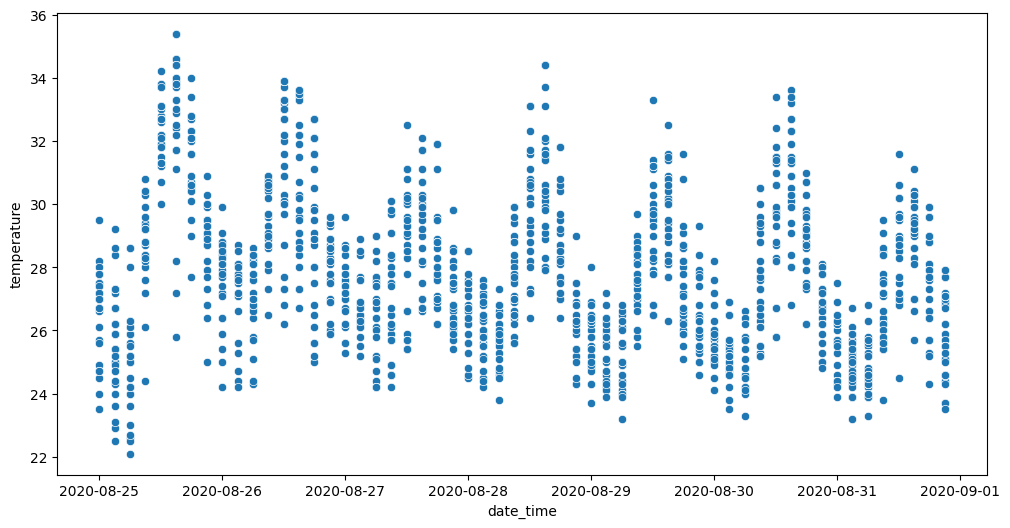

In [13]:
# 기상정보 (기온, 풍속, 습도, 강수량, 일조량)
plt.figure(figsize=(12, 6))
test.date_time = pd.to_datetime(test.date_time)
sns.scatterplot(data=test, x='date_time', y='temperature')